In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#import data
df = pd.read_csv('../Datasets/NVDA Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,25.50,26.10,26.59,24.84,150.20M,-4.42%
1,1/4/2017,26.10,25.85,26.38,25.38,119.92M,2.35%
2,1/5/2017,25.43,26.13,26.45,25.26,98.43M,-2.57%
3,1/6/2017,25.77,25.71,26.06,25.30,82.29M,1.34%
4,1/9/2017,26.82,25.88,27.00,25.88,91.62M,4.07%


In [7]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [8]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,25.50,26.10,26.59,24.84,150200000.0,-4.42%
1,1/4/2017,26.10,25.85,26.38,25.38,119920000.0,2.35%
2,1/5/2017,25.43,26.13,26.45,25.26,98430000.0,-2.57%
3,1/6/2017,25.77,25.71,26.06,25.30,82290000.0,1.34%
4,1/9/2017,26.82,25.88,27.00,25.88,91620000.0,4.07%
...,...,...,...,...,...,...,...
1606,5/22/2023,311.76,309.01,315.20,306.80,36970000.0,-0.28%
1607,5/23/2023,306.88,310.00,312.88,306.31,35470000.0,-1.57%
1608,5/24/2023,305.38,302.10,306.07,298.06,55280000.0,-0.49%
1609,5/25/2023,379.80,385.23,394.80,366.35,153460000.0,24.37%


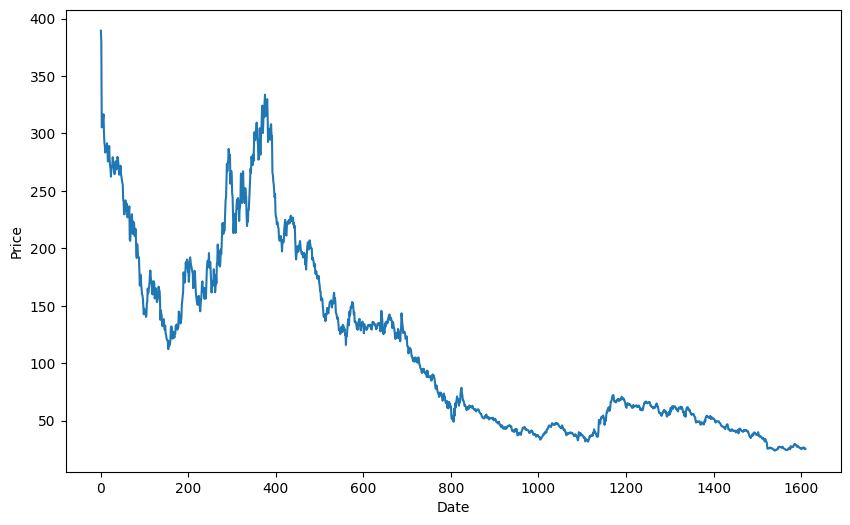

In [9]:
#Đảo ngược dữ liệu cho mô hình
df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [10]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [11]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [12]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [13]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [14]:
# Predict on validation set
my_dlm.predictN(N=30)


([31.448839024984178,
  30.162832341970677,
  31.6031793238511,
  31.110020936361515,
  31.106129452598797,
  29.127675858972857,
  29.0438207206464,
  28.376599352488327,
  27.26092415443783,
  28.310890129249497,
  27.601770979768858,
  27.43229559800254,
  27.785231406679216,
  28.33125496697854,
  28.705846019751956,
  28.090472107612012,
  28.588487862502433,
  28.04411274079677,
  27.9190593752072,
  28.563680516738195,
  27.768596094729855,
  26.950244946818177,
  26.588363523124737,
  25.776078029935054,
  26.40425722978546,
  24.77913100578485,
  24.561926701529813,
  24.457347405952273,
  24.475264222924558,
  23.872350366895095],
 [1316.8939296236667,
  1311.6860666603366,
  1306.5265445789576,
  1301.4148807656281,
  1296.3505964029232,
  1291.3332164869364,
  1286.362269842566,
  1281.4372891371477,
  1276.5578108925024,
  1271.7233754954896,
  1266.9335272071207,
  1262.1878141702891,
  1257.4857884161725,
  1252.82700586936,
  1248.2110263517325,
  1243.6374135851627,
  

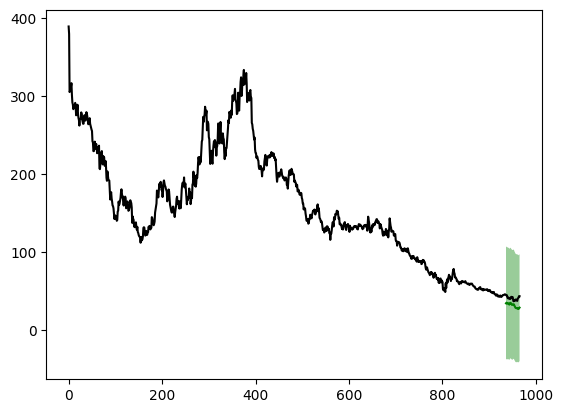

In [15]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [16]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [17]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [18]:
%pip install scikit-learn


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 95.47432511860784
Testing MSE: 9115.34675685363
Testing MAE: 84.82554952795913
Validation RMSE: 22.94716450037375
Validation MSE: 526.5723586072132
Validation MAE: 21.569574525652442


In [20]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [21]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[31.448839024984178, 30.162832341970677, 31.6031793238511, 31.110020936361515, 31.106129452598797, 29.127675858972857, 29.0438207206464, 28.376599352488327, 27.26092415443783, 28.310890129249497, 27.601770979768858, 27.43229559800254, 27.785231406679216, 28.33125496697854, 28.705846019751956, 28.090472107612012, 28.588487862502433, 28.04411274079677, 27.9190593752072, 28.563680516738195, 27.768596094729855, 26.950244946818177, 26.588363523124737, 25.776078029935054, 26.40425722978546, 24.77913100578485, 24.561926701529813, 24.457347405952273, 24.475264222924558, 23.872350366895095]


In [22]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [23]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


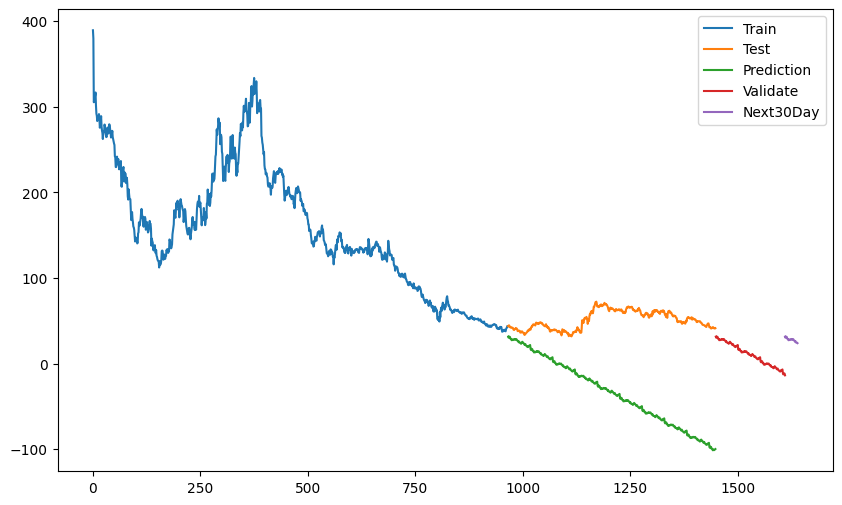

In [24]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
#plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'])
plt.show()